# Executing an NGEN Subsetting Workflow

In [ ]:
from hera.workflows import Steps, Step, Workflow, WorkflowsService
from hera.workflows.models import TemplateRef

In [ ]:
# token is obtained from https://workflows.argo.cuahsi.io/userinfo
argo_token = "v2:eyJhbGciOiJSU0EtT0FFUC0yNTYiLCJlbmMiOiJBMjU2R0NNIiwiemlwIjoiREVGIn0.Jmwv5MWyI9zAt3zM5teLzoXAu3VbTicO9I-HtPdI88nRp_ETGXkFQqC5aM_msNYlJSF5ncrugC5RexrhvxPIq5tZeWHDG9dzif6TDn1Z6G8vuicIcbwKCbhtveFWoJHUNO4rz714Rt5decdPeIwxBTJ2bKoPnK8HZtrit2fDseJOrD9EYBUSpjMZt-aiSGD7SuHye08kNggmHVEzfNOx-ehXI2doq62_bqZNNOOLR4H_p48SV2DVaQHU28yH5dVKBPoS9gQcxM0UTeadyjNm4M_I4s4-g-8tVDhzadUih6rtFw33smvK_gjon30N4mtUP2rNrhLjGy701bbj_RnFRA.7RZ66x0RfHrFzmBA.0ntF913jQdh3Urda5EOMqMI2Gzn59ttOcmfmX3dfvkLzSjktGK6UTcQE7d3lLRPejzeOrfe0LfFVjVcJDFvkQoITZIHhBtc.Q81RRcNnwtUKQ0y5hknjiw"
argo_host  = "https://workflows.argo.cuahsi.io"
argo_ns    = "workflows"

In [ ]:
ws=WorkflowsService(host=argo_host,
                   token=argo_token,
                   namespace=argo_ns)

Test the connection

In [ ]:
ws.get_info()

Define a function to print job status

In [ ]:
import time
import datetime 

def display_status(workflow):
    job_name = workflow.name

    # initial values
    finished_at = None
    start_time = None
    
    print(f'Job: {job_name}') 
    while finished_at is None:
        # query the job status
        status = workflow.workflows_service.get_workflow(job_name).status

        # set start time
        if start_time is None:
            start_time = status.started_at.__root__

        # get current time
        now = datetime.datetime.now(datetime.timezone.utc)

        # display progress
        print(f'Progress: {status.progress} ' +
              f'[{status.phase}]' + 
              f' - Elapsed time={now-start_time}', end='\r')

        # update finished time
        finished_at = status.finished_at
    
        time.sleep(1)
        
    print('')
    print(f'Finished at: {str(finished_at.__root__)}')

Connect to the Cloud Data project using Gcloud

In [ ]:
# to display the current project:
# gcloud config get project

!gcloud config set project thredds
!gcloud config get project

List storage buckets

In [ ]:
!gcloud storage ls

List the data stored in the ngen directory of `subsetter-outputs`

In [ ]:
!gcloud storage ls gs://subsetter-outputs/ngen

Create a unique identifier for our job. This will be used to create a directory for our outputs in the cloud.

In [ ]:
import uuid
job_id = uuid.uuid4().hex

## Prepare the Argo Workflow

List workflow templates that exist in our cluster.

In [ ]:
for wt in ws.list_workflow_templates().items:
    print (wt.metadata.name)

Define workflow inputs.

In [ ]:
wb_id = 'wb-2917533'
vpu_id = '16'
hydrofabric_url = 's3://nextgen-hydrofabric/pre-release/'
output_bucket = 'subsetter-outputs'
output_path = f'ngen/{job_id}'

Create a workflow that combines Parflow Subsetting and Metadata Extraction.

In [ ]:
with Workflow(
    generate_name="ngen-subsetting-job-",
    entrypoint="tasks",
    workflows_service=ws,
    namespace='workflows',
) as w:
    ngen_subset_ref = TemplateRef(
        name="ngen-subset-v1",
        template="ngen-subset-v1",
    )
    metadata_extract_ref = TemplateRef(
        name="metadata-extractor",
        template="metadata-extractor",
    )
    with Steps(name="tasks") as s:
        Step(
            name='call-ngen-subset',
            template_ref=ngen_subset_ref,

            # I'm not sure why input-bucket, input-path, output-bucket, and label need to be
            # defined here. They have default values in the template, however it they are 
            # omitted we get an error that they were not provided.
            arguments={'wb-id': wb_id,
                       'vpu-id': vpu_id,
                       'hydrofabric-url': hydrofabric_url,
                       'output-bucket': output_bucket,
                       'output-basepath': 'ngen',
                       'job-id': job_id,
                       },

            )
        Step(
            name='call-metadata-extract',
            template_ref=metadata_extract_ref,
            arguments={'bucket': output_bucket,
                       'path': output_path,
                       },
            )

Display the YAML that was created.

In [ ]:
print(w.to_yaml())

Submit the job

In [ ]:
_ = w.create()

Display the job status

In [ ]:
display_status(w)

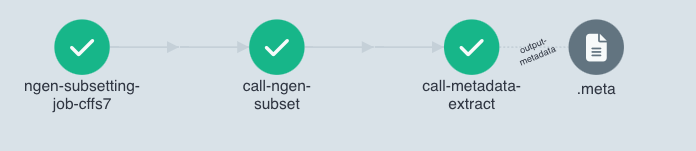

## Download the Results

In [ ]:
!gcloud storage cp -r gs://$output_bucket/$output_path .

In [ ]:
!ls -lah $job_id